## Thermally driven Convection -pt 2  

Analysis of the convection run, and more advanced behaviour

**New concepts:** Advection-diffusion solver template, thermal boundary conditions, Rayleigh number, analysis functions, interpolation

**NOTE:** I saved all the python setup of the previous notebook in a file so we don't need to type it again. We just do this:


In [1]:
%run "090-RayleighBenardConvection-setup.py"


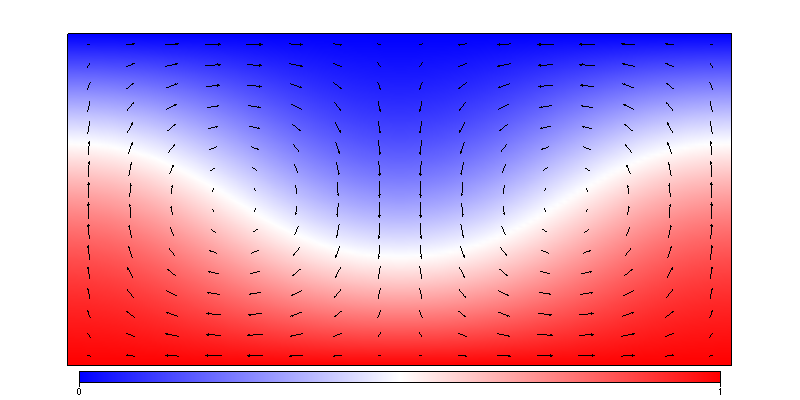

10000.0


In [2]:
# Ready ?

solver.solve()

# plot figure 

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()

print Ra

# (YES !)

## Functions

Underworld defines a special class of parallel-safe, _lazy_ functions. These are used by the finite element routines to build viscosity, buoyancy etc at all the sample points in the domain. They are only evaluated when needed (hence *lazy*) and it is the **definition** which we store, not the values. This is important ... 

The buoyancy function is a uw vector function, so is the temperature (why ?):

``` python
# Rayleigh number.
Ra = 1.0e4

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

```

Watch this:

In [3]:
## Buoyancy Function and lazy evaluation


location = (1.0,0.0)

print Ra
print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)


Ra = 1.0e8

print Ra
print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

10000.0
[[     0.  10000.]]
[[ 1.]]
100000000.0
[[     0.  10000.]]
[[ 1.]]


An alternative way to do this is to use the `constant` function which is more like a parameter-setting function.

In [4]:
# Rayleigh number.
Ra = fn.misc.constant(1.0e4)

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

Ra.value = 1.0e8

print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

[[     0.  10000.]]
[[ 1.]]
[[  0.00000000e+00   1.00000000e+08]]
[[ 1.]]


This saves us from having to rebuild the buoyancy force term and re-load it into the template every time we need to change the Rayleigh number. 

**NOTE:** if we want to use this now, we have to reload it into the template !!

In [5]:
stokes.fn_bodyforce = buoyancyFn

We can see if that worked ... 

In [6]:
time = 0.
step = 0
steps_end = 200

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1

**Plot final temperature and velocity field**


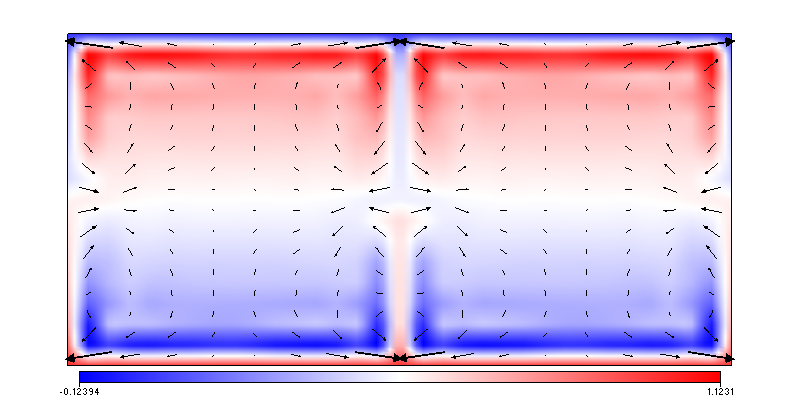

In [7]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.001) )
figtemp.show()

In [8]:
# Global max min

print fn.view.min_max(temperatureField)

# This is a function that will return the global max / min of the function's last evaluation
# THIS HAS to be done in two steps: evaluate, then ask for max / min

T_maxmin_fn = fn.view.min_max(temperatureField)
T_maxmin_fn.evaluate(mesh)

print T_maxmin_fn.min_global(), T_maxmin_fn.max_global()


-0.165604551738 1.16552231422


**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer. In the R-B convection example, that means 

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


In [9]:
nuNumerator    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuDenominator  = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]

print Nusselt

16.3027915073


The root mean squared velocity is defined by integrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $dV$ denotes an elemental volume (area) of the box.



In [10]:
int_vdotv_dV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), mesh )
int_1_dV     = uw.utils.Integral( 1.0 , mesh )

Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]

print "Volume (Area) of the mesh = ", int_1_dV.evaluate()[0]
print "Vrms = ", Vrms

Volume (Area) of the mesh =  2.0
Vrms =  42880001.6468


In [11]:
def Vrms_fn():
    Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]
    return Vrms

def Nu_fn():
    Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]
    return Nusselt


## Exercise - role of aspect ratio on convection

Compute the Nusselt / Vrms values for one Ra but different aspect ratio.
At an Ra of $10^4$ a perturbation to the initial geometry can create a
stable set of 1, 2 or 3 cells. 

How does this influence the Vrms / Nu ?


In [22]:
Ra.value = 1.0e4
cells = 1.0

In [23]:
pertStrength = 0.2

deltaTemp = tempMax - tempMin

for index, coord in enumerate(Tmesh.data):
    pertCoeff = math.cos( cells / 2.0 * math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

for index in Tmesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
    
for index in Tmesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin


In [24]:
glucifer_filename = "Ra1e4-1cell"
store = glucifer.Store(filename=glucifer_filename)
frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh, temperatureField, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=1.0/Ra.value) )

In [25]:
time = 0.
step = 0
steps_end = 500

Nusselt_t = np.empty(steps_end)
Vrms_t = np.empty(steps_end)
times_t = np.empty(steps_end)

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)  ## <- The explicit timestep computations
    
    time += dt
    
    Nusselt_t[step] = Nu_fn()
    Vrms_t[step] = Vrms_fn()
    times_t[step] = time
    
    if step%5 == 0:
        store.step=step
        frames.save()
        print("Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1

    
    

Step = 0 | time = 0.0 | Nusselt = 1.0 | Vrms = 1289.76950684
Step = 5 | time = 0.00214496571421 | Nusselt = 1.16446352556 | Vrms = 2079.09667998
Step = 10 | time = 0.0038122301113 | Nusselt = 1.3743945645 | Vrms = 3201.70874128
Step = 15 | time = 0.00520406524845 | Nusselt = 1.6356827105 | Vrms = 4382.26252491
Step = 20 | time = 0.00642413925591 | Nusselt = 1.94951580673 | Vrms = 5514.63907786
Step = 25 | time = 0.00753399527106 | Nusselt = 2.31343155731 | Vrms = 6508.84722193
Step = 30 | time = 0.00857436685548 | Nusselt = 2.72087982277 | Vrms = 7298.2108929
Step = 35 | time = 0.00957477720771 | Nusselt = 3.16109236215 | Vrms = 7841.71220766
Step = 40 | time = 0.0105575552116 | Nusselt = 3.61915686577 | Vrms = 8122.52462516
Step = 45 | time = 0.0115425420606 | Nusselt = 4.07781150365 | Vrms = 8145.34850517
Step = 50 | time = 0.0125483742877 | Nusselt = 4.51846178057 | Vrms = 7930.73461835
Step = 55 | time = 0.0135927610358 | Nusselt = 4.92201341232 | Vrms = 7509.85181573
Step = 60 | t

Step = 490 | time = 0.194890236631 | Nusselt = 4.11901876769 | Vrms = 2428.39414487
Step = 495 | time = 0.196975636548 | Nusselt = 4.12504920114 | Vrms = 2438.56607385


In [26]:
view = glucifer.lavavu.Viewer(database="{}.gldb".format(glucifer_filename))
# print(view.steps)

view.control.Panel()
view.control.Checkbox(property='axis')
view.control.ObjectList()
view.control.TimeStepper()
view.control.show()

<IPython.core.display.Javascript object>

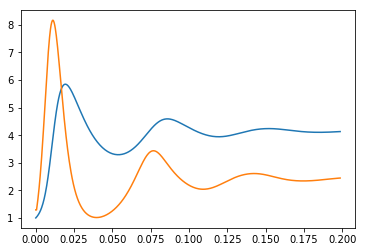

In [27]:
## Make a plot of Nu / Vrms against time

%matplotlib inline

from matplotlib import pyplot as plt

graph = plt.Figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(times_t, Nusselt_t)
ax.plot(times_t, Vrms_t*0.001)




In [28]:
print("Nusselt_no at final state - {}".format(Nusselt_t[-1]))
print("Vrms at final state - {}".format(Vrms_t[-1]))

Nusselt_no at final state - 4.13009779547
Vrms at final state - 2445.53744653
